# Script 2: Process EEG data after audio transcription

**Python Code to Accompany Douglas, Tremblay, and Newman, "A two for one special: EEG hyperscanning using an existing single-person EEG recording setup"**

---
Copyright (c) 2021 Aaron J Newman & Caitriona L Douglas, NeuroCognitive Imaging Lab, Dalhousie University

This program is free software; you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation; either version 2 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with this program; if not, write to the Free Software Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA 02110-1301, USA.

---

## Load in necessary libraries/pacakges we need

This script was developed and run using the following versions of software:
- Python 3.8.5
- NumPy 1.19.2
- pandas 1.2.1
- MNE 0.22.0

In [1]:
import numpy as np
import pandas as pd
import glob, os
import mne
mne.set_log_level(verbose='error')

### Set Parameters 

In [2]:
# "Subject" is the name of your input file, without the extensions
subject = 'conversation_eeg_sample'

# Input should be continuous EEG data 
raw_fname = subject + '.vhdr'

# Filter cutoffs and other parameters
l_freq_use = 0.1
l_freq_ICA = 1.0
h_freq = 20.0

# specify the time window for epoching
tmin = -0.2  # start of each epoch (in sec)
tmax =  1.0  # end of each epoch (in sec)

# maximum number of ICs to reject in ICA artifact correction
ica_random_state = 42  # seed so ICA is reproducable each time it's run
# Specify n_components as a decimal to set % explained variance
n_components = .99

baseline = (None, 0)  # means from the first instant to t = 0
reject = dict(eeg=200e-6, eog=200e-6)  # EEG data are in V, so e-6 gives microVolts

# standard montage file to look up channel locations
montage_fname = 'standard_1005'

## Import data

In [3]:
raw_decim = mne.io.read_raw_fif(subject + '_decim-raw.fif', preload=True)

## Convert EMG channels to bipolar
Sutract one channel from another, and replace the two "source" channels with the new one reflecting the difference between them.

In [4]:
mne.set_bipolar_reference(raw_decim, 
                          ['P1_RN','P1_LMass','P1_LN','P1_RMass'],
                          ['P2_RN','P2_LMass','P2_LN','P2_RMass'], 
                          ch_name=['P1_EMG_L', 'P2_EMG_L','P1_EMG_R','P2_EMG_R'], 
                          ch_info=None, 
                          copy=False)

<Raw | conversation_eeg_sample_decim-raw.fif, 62 x 307550 (615.1 s), ~145.5 MB, data loaded>

## Filtering

Below we use ICA to identify and remove certain artifacts linke blinks. ICA works best on bandpass-filtered data with a highpass cutoff of 1 Hz. However, detection of ERPs should be done with data filtered with a lowpass filter of 0.1 Hz. So we create two filtered copies of the data, one for ICA and one for ERP derivation. We compute the ICA decomposition on the 1 Hz filtered data and then apply it to the 0.1 Hz filtered data after artifacts are removed. 

In [5]:
raw_decim_use = raw_decim.copy()

# filter for input to ICA
raw_decim.filter(l_freq_ICA, h_freq)  

# Filter for ERP derviation
raw_decim_use.filter(l_freq_use, h_freq);

## Epoching (Segmentation)

### Import word onset timings, create event codes

Word onset times are manually entered into a CSV file, which contains three columns: 
1. `text`, which specifies the word or a code for a category of words (in this example, noun onsets were marked and coded as  `NN`)
2. `onset_time`, which specifies the time of onset of each word (relative to the start of the EEG/audio file)
3. `dontuse`, which is 0 for all usable words, but 1 for words which were garbeld, misspoken, or otherwise determined not to be usable for ERP analysis.

#### Event code mapping

Beacuse the MNE `events` structure is a NumPy array, we need to map each unique value in the `word` column on the timings file, to a unique integer to represent that code in the events structure. Here we use a Python dictionary to specify the mapping. In the present example all words are coded the same, as "NN". However, any number of disctinctive codes can be created and mapped to unique integers.

In [6]:
word_codes = {'P1_heard':1,
             'P2_heard':2}  

In [7]:
timings_file = subject + '.csv'
word_timings = pd.read_csv(timings_file)

# the Events data structure represents the 'when' in terms of samples
# not time. So convert seconds to samples
word_timings['onset_time'] = word_timings['onset_time'] * raw_decim.info['sfreq']

In [8]:
events = np.c_[word_timings['onset_time'], 
               word_timings['dontuse'], 
               word_timings['text'].map(word_codes)
              ].astype(int)

# remove any events flagged as "don't use"
events = events[events[:,1] != 1]


### Visualize event timings
This shows when each word was heard by each participant.

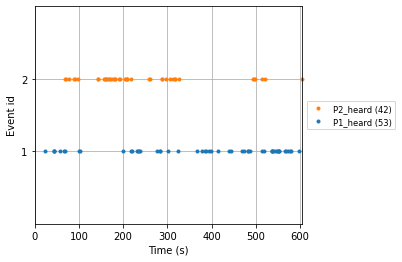

In [9]:
mne.viz.plot_events(events, raw_decim.info['sfreq'], event_id=word_codes);

### Segment into epochs and separate into separate Epochs data structures for each participant
Do for both the inputs to ICA and to ERP derivation

In [10]:
p1_epochs = mne.Epochs(raw_decim, events, word_codes['P1_heard'],
                    tmin, tmax, 
                    proj=False,
                    baseline=baseline, 
                    detrend=1,
                    preload=True)

p1_epochs_use = mne.Epochs(raw_decim_use, events, word_codes['P1_heard'],
                        tmin, tmax, 
                        proj=False,
                        baseline=baseline, 
                        detrend=1,
                        preload=True)

In [11]:
len(p1_epochs)

53

In [12]:
p2_epochs = mne.Epochs(raw_decim, events, word_codes['P2_heard'],
                    tmin, tmax, 
                    proj=False,
                    baseline=baseline, 
                    detrend=1,
                    preload=True)

p2_epochs_use = mne.Epochs(raw_decim_use, events, word_codes['P2_heard'],
                        tmin, tmax, 
                        proj=False,
                        baseline=baseline, 
                        detrend=1,
                        preload=True)

In [13]:
len(p2_epochs)

42

### Drop the channels belonging to the other participant

In [14]:
p1_unused_chans = ['P2_Fp1','P2_Fp2','P2_F7','P2_F3','P2_Fz','P2_F4','P2_F8','P2_FC5',
                   'P2_FC1','P2_FC2','P2_FC6','P2_T7','P2_C3','P2_Cz','P2_C4','P2_T8',
                   'P2_TP9','P2_CP5','P2_CP1','P2_CP2','P2_CP6','P2_TP10','P2_P3',
                   'P2_Pz','P2_P4','P2_O1','P2_Oz','P2_O2','P2_EMG_L','P2_EMG_R',
                   'P2_Canthi']

p1_epochs.drop_channels(p1_unused_chans)
p1_epochs_use.drop_channels(p1_unused_chans)


p2_unused_chans = ['P1_Fp1','P1_Fp2','P1_F7','P1_F3','P1_Fz','P1_F4','P1_F8','P1_FC5',
                   'P1_FC1','P1_FC2','P1_FC6','P1_T7','P1_C3','P1_Cz','P1_C4','P1_T8',
                   'P1_TP9','P1_CP5','P1_CP1','P1_CP2','P1_CP6','P1_TP10','P1_P3',
                   'P1_Pz','P1_P4','P1_O1','P1_Oz','P1_O2','P1_EMG_L','P1_EMG_R',
                   'P1_Canthi']

p2_epochs.drop_channels(p2_unused_chans)
p2_epochs_use.drop_channels(p2_unused_chans);

### Rename remaining channels 

Strip off the participant identifiers, so that channel names match MNE's expected 10-10 system labels

In [15]:
p1_channel_names = {'P1_Fp1':'Fp1', 'P1_Fp2':'Fp2', 'P1_F7':'F7', 'P1_F3':'F3', 'P1_Fz':'Fz', 
                    'P1_F4':'F4', 'P1_F8':'F8', 'P1_FC5':'FC5', 'P1_FC1':'FC1', 'P1_FC2':'FC2', 
                    'P1_FC6':'FC6', 'P1_T7':'T7', 'P1_C3':'C3', 'P1_Cz':'Cz', 'P1_C4':'C4', 
                    'P1_T8':'T8', 'P1_TP9':'TP9', 'P1_CP5':'CP5', 'P1_CP1':'CP1', 'P1_CP2':'CP2', 
                    'P1_CP6':'CP6', 'P1_TP10':'TP10', 'P1_P3':'P3', 'P1_Pz':'Pz', 
                    'P1_P4':'P4', 'P1_O1':'O1', 'P1_Oz':'Oz', 
                    'P1_O2':'O2', 'P1_Canthi':'EOG'}

p2_channel_names = {'P2_Fp1':'Fp1', 'P2_Fp2':'Fp2', 'P2_F7':'F7', 
                    'P2_F3':'F3', 'P2_Fz':'Fz', 'P2_F4':'F4', 'P2_F8':'F8', 'P2_FC5':'FC5', 'P2_FC1':'FC1', 
                    'P2_FC2':'FC2', 'P2_FC6':'FC6', 'P2_T7':'T7', 'P2_C3':'C3', 'P2_Cz':'Cz', 'P2_C4':'C4', 
                    'P2_T8':'T8', 'P2_TP9':'TP9', 'P2_CP5':'CP5', 'P2_CP1':'CP1', 'P2_CP2':'CP2', 
                    'P2_CP6':'CP6', 'P2_TP10':'TP10', 'P2_P3':'P3', 'P2_Pz':'Pz', 
                    'P2_P4':'P4', 'P2_O1':'O1', 'P2_Oz':'Oz', 
                    'P2_O2':'O2', 'P2_Canthi':'EOG'}

mne.rename_channels(p1_epochs.info, p1_channel_names)
mne.rename_channels(p1_epochs_use.info, p1_channel_names)
mne.rename_channels(p2_epochs.info, p2_channel_names)
mne.rename_channels(p2_epochs_use.info, p2_channel_names)

### Set Electrode positions

In [16]:
p1_epochs.set_montage(montage_fname)
p2_epochs.set_montage(montage_fname)
p1_epochs_use.set_montage(montage_fname)
p2_epochs_use.set_montage(montage_fname);

### Re-reference each data set to the average of all channels

Data were recorded with a ground splitter and average reference. This means that data from each active electrode on each participant contains noise from the other participant. Having separated the data by participant, we now re-reference the data to the average of all channels *only* from that individual. Noise common to all channels of that individual (which should include noise contributed by the other participant) should be eliminated or at least significantaly attenuated. 

In [17]:
p1_epochs = mne.set_eeg_reference(p1_epochs)[0]
p2_epochs = mne.set_eeg_reference(p2_epochs)[0]
p1_epochs_use = mne.set_eeg_reference(p1_epochs_use)[0]
p2_epochs_use = mne.set_eeg_reference(p2_epochs_use)[0];

---
### From here on, we process each participant's data set separately, starting with P1

# P1

## Interactive plot of data - identify and mark bad channels and epochs


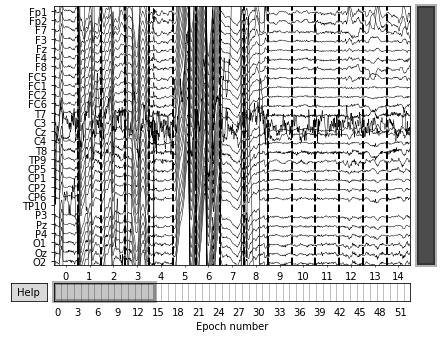

In [18]:
%gui qt

p1_epochs.plot(n_channels=34, 
               n_epochs=15, 
               scalings=dict(eeg=.0001, eog=.0005, emg=.0005),
               decim=4,
               title='P1');

### List any bad channels that you found in the interactive plot, in `bads`

In [19]:
p1_bads = ['TP10', 'C3','T7','TP9','T8','Cz']

# List any bad channels
p1_epochs.info['bads'] = p1_bads
# Re-reference to average that doesn't include bad channels
p1_epochs = mne.set_eeg_reference(p1_epochs)[0]

# apply to less-filtered data as well
p1_epochs_use.info['bads'] = p1_bads
p1_epochs_use = mne.set_eeg_reference(p1_epochs_use)[0]

### Plot data with bad channels removed

Use this to identify any "paroxysmal" trials with particular/unique artifacts that might cause problems for ICA

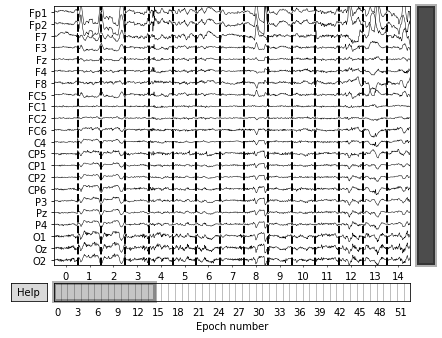

In [20]:
p1_epochs.plot(n_channels=34, 
               n_epochs=15, 
               scalings=dict(eeg=.0001, eog=.0005, emg=.0005),
               decim=4,
               title='P1');

### List any bad trial numbers in `rej_trials`

In [21]:
# list any bad trials
rej_trials = [] 
    
p1_epochs.drop(rej_trials)
p1_epochs_use.drop(rej_trials);

## Run ICA to identify and remove artifacts

In [22]:
ica = mne.preprocessing.ICA(n_components=n_components, method='fastica', 
                            max_iter=500, random_state=ica_random_state)

picks = mne.pick_types(p1_epochs.info, 
                       eeg=True, eog=False, emg=False, misc=False, stim=False, meg=False, 
                       exclude='bads')

ica.fit(p1_epochs, picks=picks, decim=3, reject=None)

<ICA | epochs decomposition, fit (fastica): 10653 samples, 8 components, channels used: "eeg">

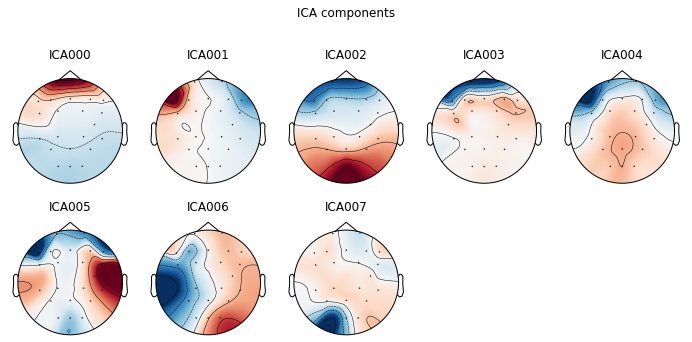

In [23]:
%matplotlib inline
ica.plot_components(picks=None, ch_type='eeg');

### Plot individual components and do manual artifact selection

Our criteria for rejection are:
1. Obvious ocular artifact (blinks weigh heavily on anterior channels, all same polarity; horizontal movements weight heavily on either side of the eyes, with opposite polarity on each side)
- Raster plots show that component weights heavily on a very low number of trials, and little/not at all on most trials
- "Epochs variance" is high on a low number of trials, but generally low on most trials
- Topo plot shows a very focal effect around a single electrode, with very little/no weighting at most other electrodes (keeping in mind that the topo plots are interpolated so there will be some "smearing" of an effect even at a single electrode) 

User needs to manually change the "picks" number for each plot based on visual inspection of the topo plots of the components, above.

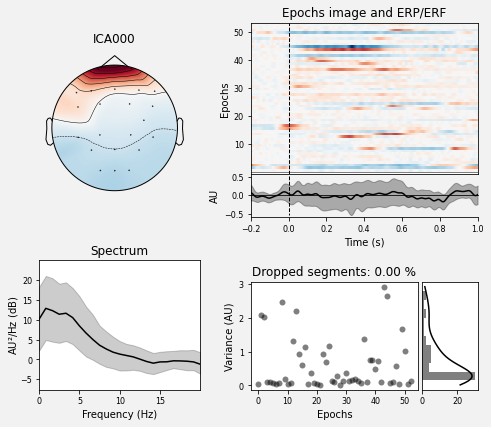

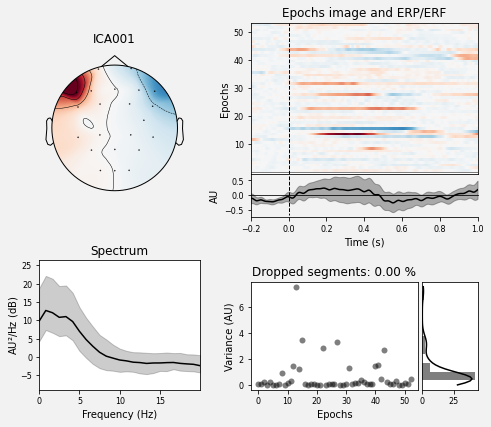

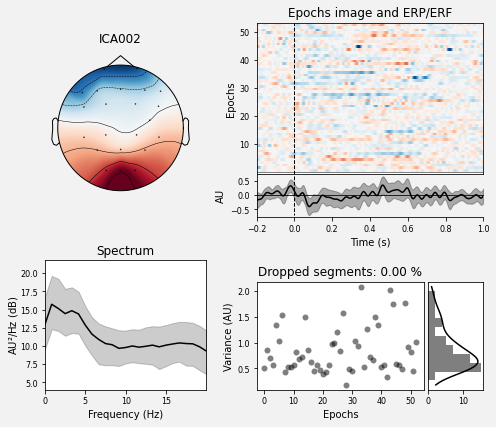

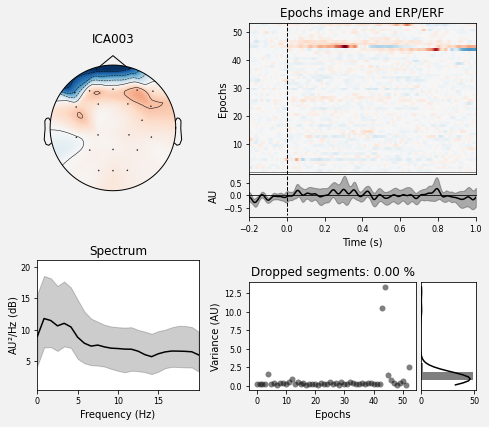

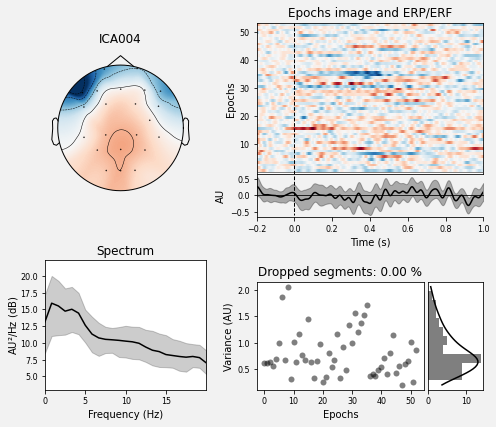

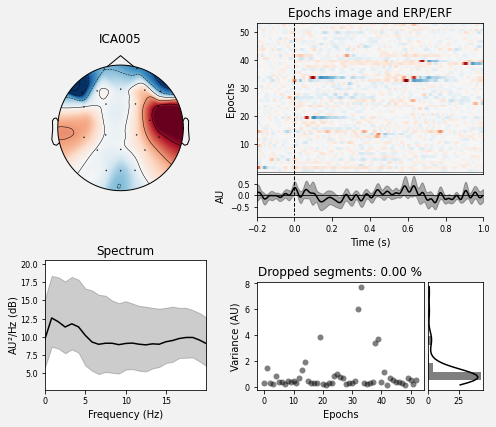

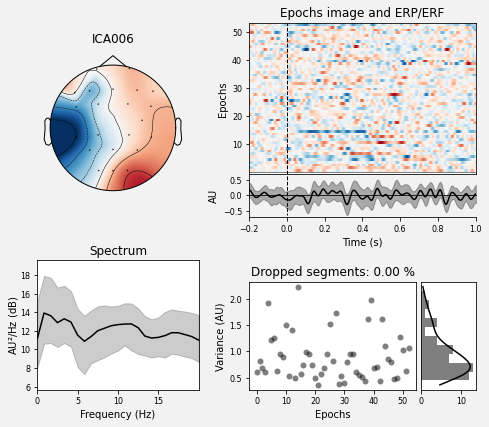

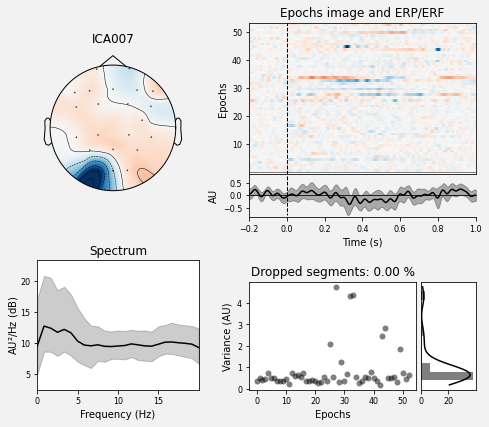

In [24]:
ica.plot_properties(p1_epochs, 
                    picks=range(0, ica.n_components_), 
                    psd_args={'fmax': h_freq});

### Manually specify ICs to remove, based on visual inspection
The automatic process doesn't remove as many ICs as necessary for EEG

In [25]:
ica.exclude = [0, 1, 3, 7]

### Apply ICA corrections to data

We apply these to the `_use` data that were highpass filtered at 0.01 Hz

In [26]:
p1_epochs_postica = ica.apply(p1_epochs_use).apply_baseline(baseline)

## Interpolate data for bad electrodes previously removed

In [27]:
p1_epochs_postica.interpolate_bads();

## Visualize cleaned data
### Individual trials

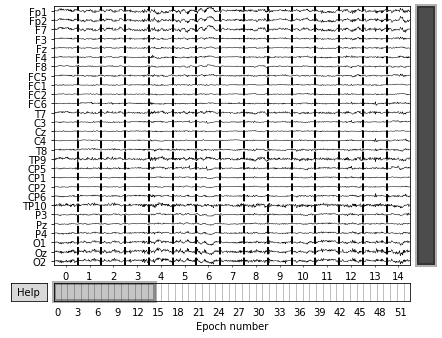

In [28]:
%gui qt

p1_epochs_postica.plot(n_channels=32,
                       n_epochs=15, 
                       scalings=dict(eeg=.0001, eog=.0005, emg=.00045),
                       decim=4,
                       title='P1 Post-ICA');

### Averaged across trials

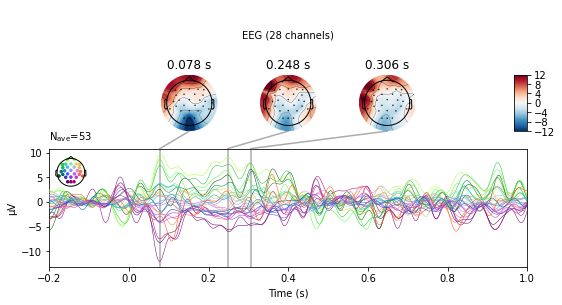

In [29]:
%matplotlib inline
p1_epochs_postica.average().plot_joint();

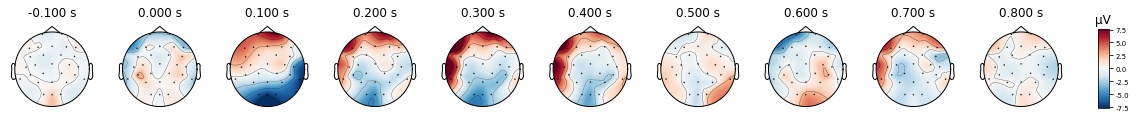

In [30]:
times = np.arange(tmin+.1, tmax-.1, 0.1)
p1_epochs_postica.average().plot_topomap(times=times);

### Save ICA-corrected data 

This is saved in FIF file format as an MNE Epochs object

In [31]:
p1_epochs_postica.save(subject + '-P1-epo.fif', overwrite=True)

Overwriting existing file.


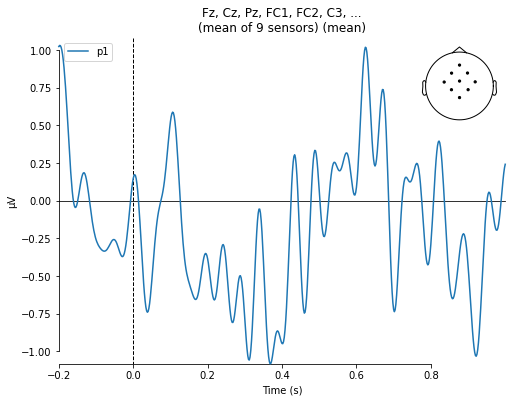

[<Figure size 576x432 with 2 Axes>]

In [32]:
ROI_labels = ["Fz", "Cz", "Pz", "FC1", "FC2", "C3", "C4", "CP1", "CP2"]

p1_evoked = p1_epochs_postica.average().apply_baseline(baseline)

mne.viz.plot_compare_evokeds(dict(p1=p1_evoked),
                             legend='upper left', show_sensors='upper right', picks= ROI_labels, combine = 'mean')

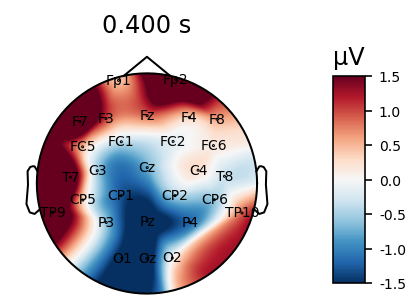

In [33]:
import matplotlib

matplotlib.rcParams['figure.dpi'] = 144

uv_range = 1.5

p1_avg = {}

p1_avg = p1_epochs_postica.average().apply_baseline(baseline)


fig=p1_avg.plot_topomap(times=.400, average=.200, 
                    ch_type='eeg', show_names=True, colorbar=True, contours=False,
                             size=1.5, res=256,
                    vmin=-uv_range, vmax=uv_range,
                    image_interp='bicubic',
                    sensors=True);

---
# P2

## Interactive plot of data - identify and mark bad channels and epochs


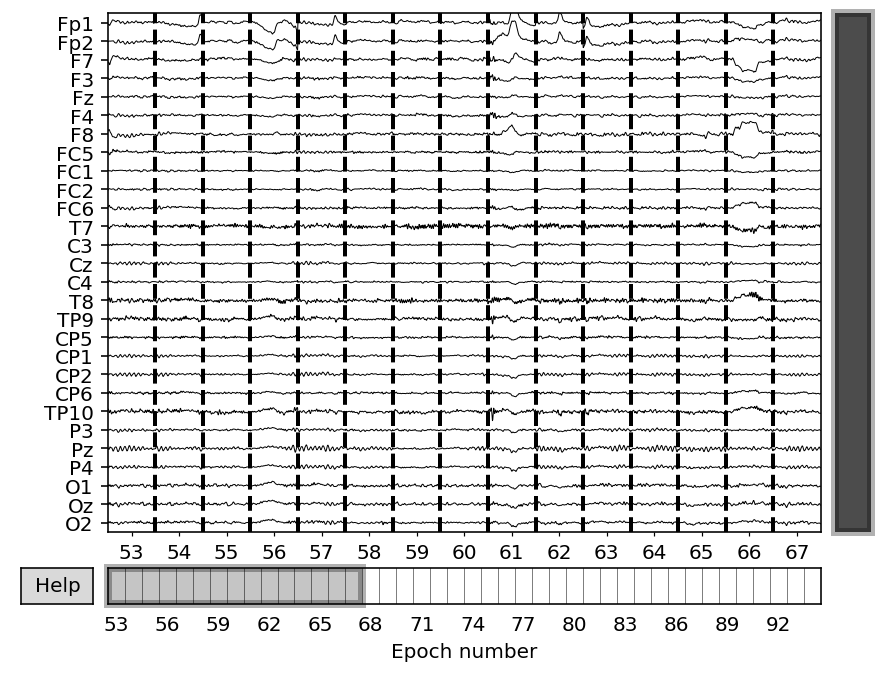

In [34]:
%gui qt
p2_epochs.plot(n_channels=34, 
               n_epochs=15, 
               scalings=dict(eeg=.0001, eog=.0005, emg=.0005),
               decim=4,
               title='P2');

### List any bad channels that you found in the interactive plot, in `bads`

In [35]:
p2_bads = []

# List any bad channels
p2_epochs.info['bads'] = p2_bads
# Re-reference to average that doesn't include bad channels
p2_epochs = mne.set_eeg_reference(p2_epochs)[0]

# apply to less-filtered data as well
p2_epochs_use.info['bads'] = p2_bads
p2_epochs_use = mne.set_eeg_reference(p2_epochs_use)[0]

### List any bad trial numbers in `rej_trials`

In [36]:
# list any bad trials
rej_trials = [] 
    
p2_epochs.drop(rej_trials)
p2_epochs_use.drop(rej_trials);

## Run ICA to identify and remove artifacts

In [37]:
ica = mne.preprocessing.ICA(n_components=n_components, method='fastica', 
                            max_iter=500, random_state=ica_random_state)

picks = mne.pick_types(p2_epochs.info, 
                       eeg=True, eog=False, emg=False, misc=False, stim=False, meg=False, 
                       exclude='bads')

ica.fit(p2_epochs, picks=picks, decim=3, reject=None)

<ICA | epochs decomposition, fit (fastica): 8442 samples, 15 components, channels used: "eeg">

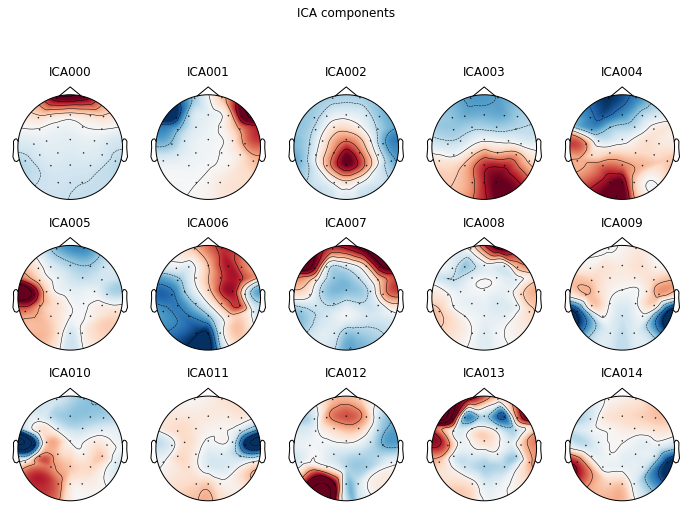

In [38]:
%matplotlib inline
ica.plot_components(picks=None, ch_type='eeg');

### Plot individual components and do manual artifact selection

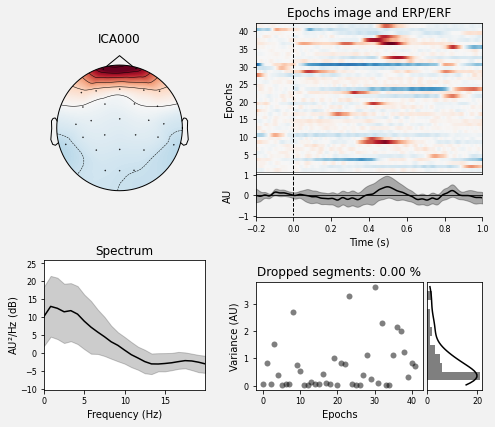

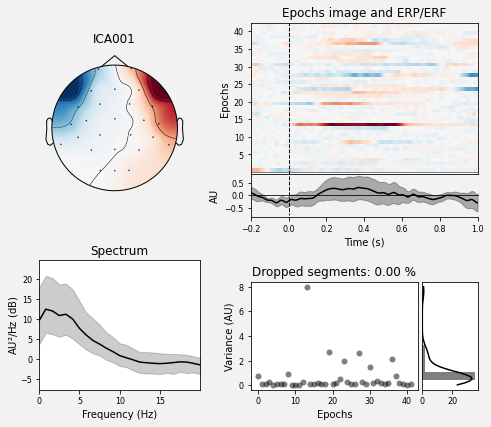

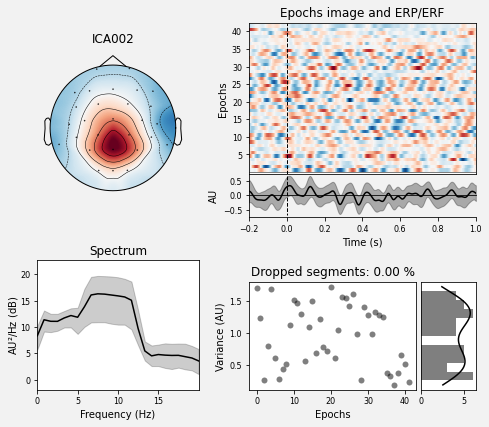

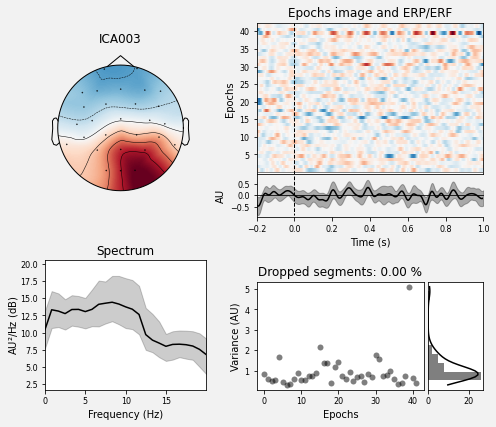

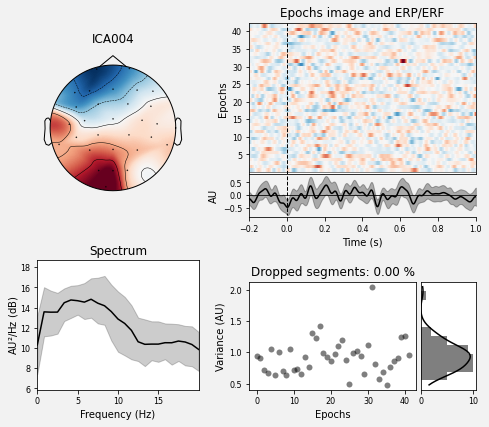

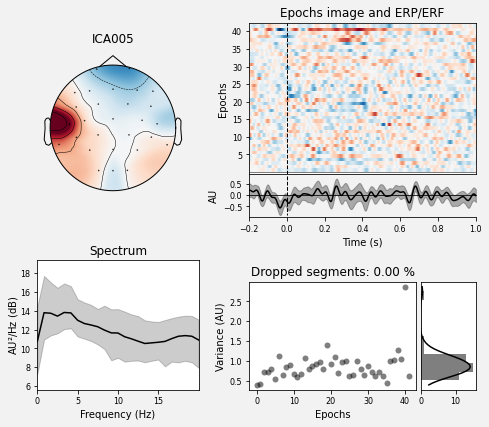

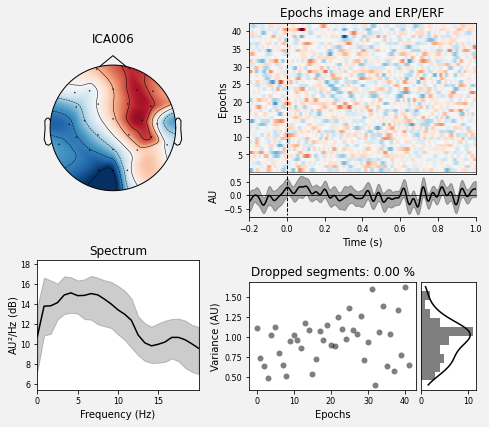

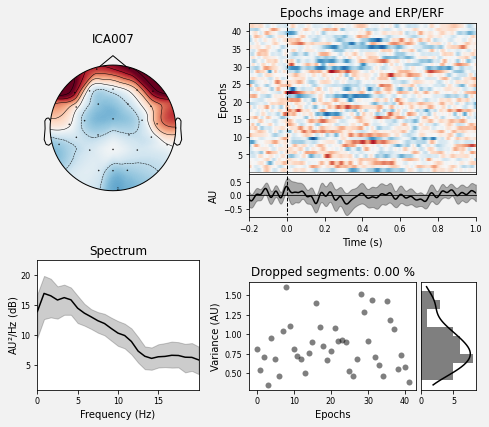

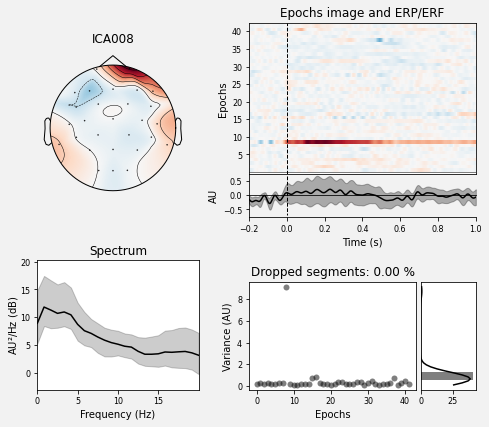

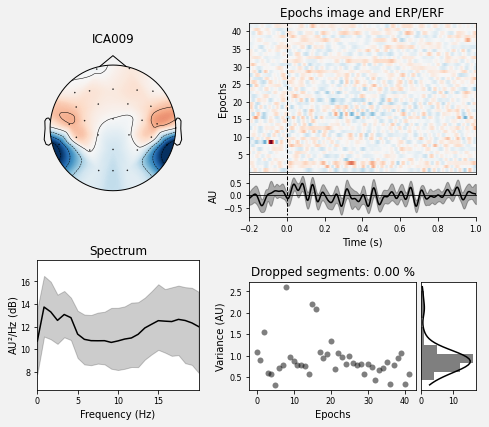

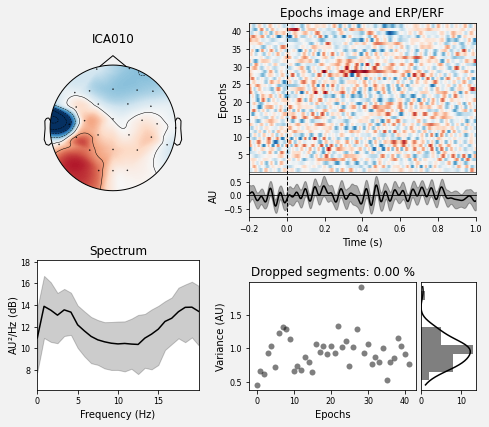

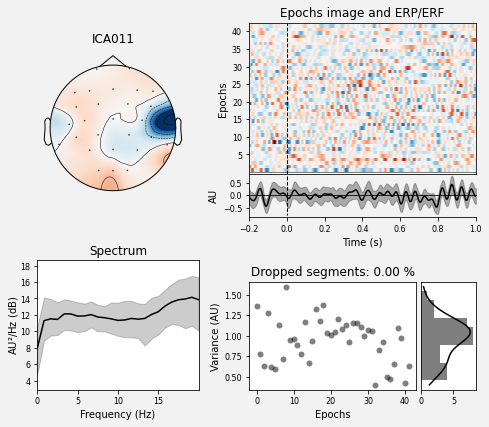

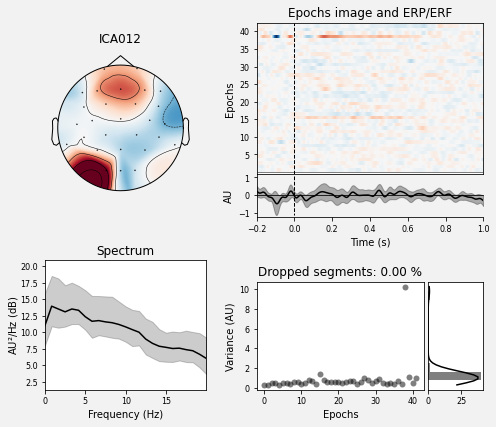

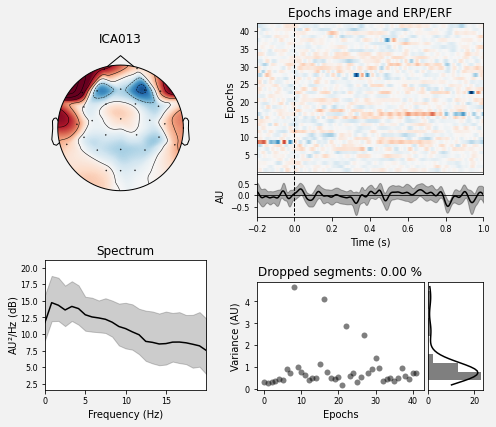

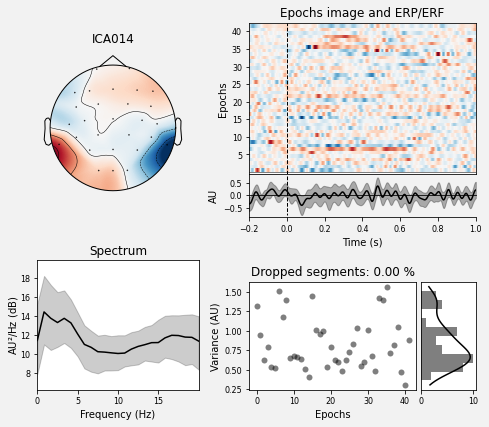

In [39]:
ica.plot_properties(p2_epochs, 
                    picks=range(0, ica.n_components_), 
                    psd_args={'fmax': h_freq});

### Manually specify ICs to remove, based on visual inspection
The automatic process doesn't remove as many ICs as necessary for EEG

In [40]:
ica.exclude = [0,1,8,13]

### Apply ICA corrections to data

We apply these to the `_use` data that were highpass filtered at 0.01 Hz

In [41]:
p2_epochs_postica = ica.apply(p2_epochs_use).apply_baseline(baseline)

## Interpolate data for bad electrodes previously removed

In [42]:
p2_epochs_postica.interpolate_bads();

## Visualize cleaned data
### Individual trials

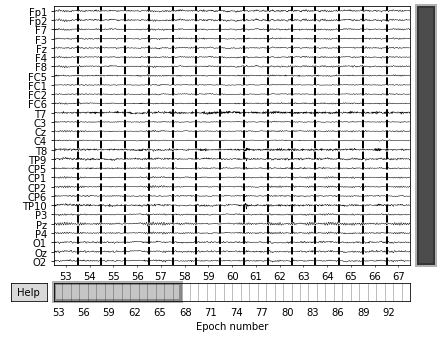

In [43]:
%gui qt
p2_epochs_postica.plot(n_channels=32,
                       n_epochs=15, 
                       scalings=dict(eeg=.0001, eog=.0005, emg=.00045),
                       decim=4,
                       title='P2 Post-ICA');

### Averaged across trials

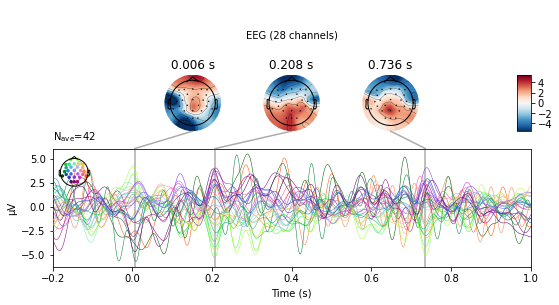

In [44]:
%matplotlib inline%gui qt
p2_epochs_postica.plot(n_channels=32,
                       n_epochs=15, 
                       scalings=dict(eeg=.0001, eog=.0005, emg=.00045),
                       decim=4,
                       title='P2 Post-ICA');
p2_epochs_postica.average().plot_joint();

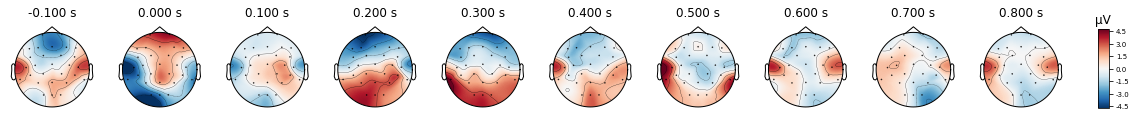

In [45]:
times = np.arange(tmin+.1, tmax-.1, 0.1)
p2_epochs_postica.average().plot_topomap(times=times);

### Save ICA-corrected data 

This is saved in FIF file format as an MNE Epochs object

In [46]:
p2_epochs_postica.save(subject + '-P2-epo.fif', overwrite=True)

Overwriting existing file.


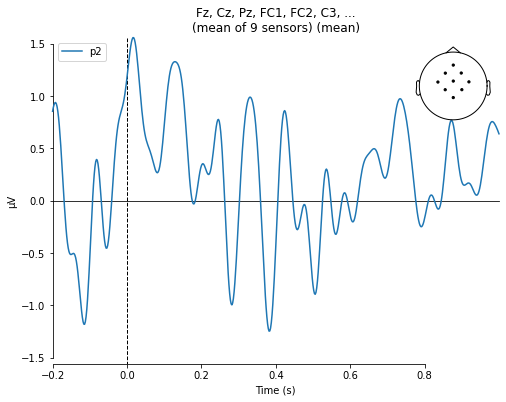

[<Figure size 576x432 with 2 Axes>]

In [47]:
ROI_labels = ["Fz", "Cz", "Pz", "FC1", "FC2", "C3", "C4", "CP1", "CP2"]

p2_evoked = p2_epochs_postica.average().apply_baseline(baseline)

mne.viz.plot_compare_evokeds(dict(p2=p2_evoked),
                             legend='upper left', show_sensors='upper right', picks= ROI_labels, combine = 'mean')

In [1]:
matplotlib.rcParams['figure.dpi'] = 144

uv_range = 1.5

p2_avg = {}

p2_avg = p2_epochs_postica.average().apply_baseline(baseline)


fig=p2_avg.plot_topomap(times=.400, average=.200, 
                    ch_type='eeg', show_names=True, colorbar=True, contours=False,
                             size=1.5, res=256,
                    vmin=-uv_range, vmax=uv_range,
                    image_interp='bicubic',
                    sensors=True);

NameError: name 'matplotlib' is not defined